I am going to build a Large Language model and yeah ..that's it

#1.EDA


In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.9.0+cpu
tiktoken version: 0.12.0


In [ ]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

class TextdatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
 def __len__(self):
        return len(self.input_ids)

 def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [ ]:

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = TextdatasetV1atasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    # Corrected typo here
    dataset = TextdatasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [ ]:

 for batch in dataloader:
  x,y = batch

  token_embeddingd=token_embedding_layer(x)
  pos_embeddings=pos_embedding_layer(torch.arange(max_length))

  input_embeddings=token_embeddingd+pos_embeddings

  break

In [ ]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])


#1.Attention Mechanisms

multi head attention

In [ ]:
import torch
import torch.nn as nn

class CausalSelfAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x):
    b, n_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores.masked_fill_(self.mask[:n_tokens, :n_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.num_heads = num_heads
    self.d_out = d_out
    self.heads = nn.ModuleList(
        [CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias)
         for _ in range(num_heads)]
    )
    self.out_proj = nn.Linear(num_heads * d_out, d_out)

  def forward(self, x):

    context_vecs = torch.cat([head(x) for head in self.heads], dim=-1)

    return self.out_proj(context_vecs)

In [ ]:
torch.manual_seed(123)

d_in = output_dim
d_out = output_dim
num_heads = 8
context_length = max_length
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads)

batch = input_embeddings
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)


context_vecs.shape: torch.Size([8, 4, 256])


Implementing the GPT text to generate words

In [ ]:
import torch.nn as nn
import torch

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )

    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

  def forward(self,x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut


    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

  def generate_text_Simple(self, idx, max_new_tokens, context_length):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_length:]

      with torch.no_grad():
        logits = self(idx_cond)


      logits = logits[:, -1, :]
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)
      idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [ ]:
import tiktoken
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

def main():
  GPT_CONFIG_124M={
    "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
  }

  torch.manual_seed(123)
  model=GPTModel(GPT_CONFIG_124M)
  model.eval()

  start_context="Hello, I am"

  tokenizer=tiktoken.get_encoding("gpt2")
  encoded=tokenizer.encode(start_context)
  encoded_tensor=torch.tensor(encoded).unsqueeze(0)

  print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
  print("\nInput text:", start_context)
  print("Encoded input text:", encoded)
  print("encoded_tensor.shape:", encoded_tensor.shape)

  out=model.generate_text_Simple(
      idx=encoded_tensor,
      max_new_tokens=10,
      context_length=GPT_CONFIG_124M["context_length"]
  )

  decoded_text=tokenizer.decode(out.squeeze(0).tolist())
  print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
  print("\nOutput:", out)
  print("Output length:", len(out[0]))
  print("Output text:", decoded_text)


if __name__ == "__main__":
    main()


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716,  1686, 17362, 37021,  6805, 33311, 40953,
         29515, 46248,  6723,  5409]])
Output length: 14
Output text: Hello, I amaps BaseballEdge components Keeping loosenetsksomeone SS decide


In [ ]:
import matplotlib.pyplot as plt
import os
import requests
import torch
import tiktoken


In [4]:
from  llms_from_scratch.ch04 import GPTModel

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
       token_ids = generate_text_simple(
    model=model,  # Pass model as an argument
    idx=encoded,
    max_new_tokens=50,
    context_size=context_size
)
decoded_text = token_ids_to_text(token_ids, tokenizer)
print(decoded_text.replace("\n", " "))  # Compact print format
model.train()

Every effort moves you rentingetic wasnم refres RexMeCHicular stren


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show() # Ensure plt.show() is called


def main(gpt_config, settings):

    torch.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    file_path = "the-verdict.txt"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # Model initialization
    model = GPTModel(gpt_config)
    model.to(device)

    # Optimizer setup
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    # Dataloader creation
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    tokenizer = tiktoken.get_encoding("gpt2")

    # Training loop call
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=5, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )

    return train_losses, val_losses, tokens_seen, model

In [ ]:
model = GPTModel(gpt_config)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )



Ep 1 (Step 000000): Train loss 9.812, Val loss 9.846
Ep 1 (Step 000005): Train loss 7.588, Val loss 8.044
Ep 2 (Step 000010): Train loss 6.582, Val loss 6.800
Ep 2 (Step 000015): Train loss 5.920, Val loss 6.592
Ep 3 (Step 000020): Train loss 15.767, Val loss 16.154
Ep 3 (Step 000025): Train loss 5.494, Val loss 6.384
Ep 4 (Step 000030): Train loss 4.373, Val loss 6.328
Ep 4 (Step 000035): Train loss 2.824, Val loss 6.258
Ep 5 (Step 000040): Train loss 3.969, Val loss 6.221
Ep 6 (Step 000045): Train loss 2.638, Val loss 6.221
Ep 6 (Step 000050): Train loss 3.156, Val loss 6.194
Ep 7 (Step 000055): Train loss 2.676, Val loss 6.162
Ep 7 (Step 000060): Train loss 1.728, Val loss 6.274
Ep 8 (Step 000065): Train loss 0.933, Val loss 6.259
Ep 8 (Step 000070): Train loss 1.371, Val loss 6.272
Ep 9 (Step 000075): Train loss 0.762, Val loss 6.329
Ep 9 (Step 000080): Train loss 0.563, Val loss 6.462
Ep 10 (Step 000085): Train loss 0.358, Val loss 6.542


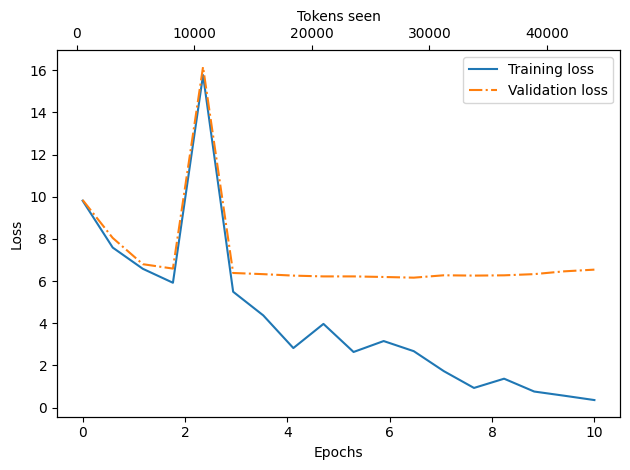

<Figure size 640x480 with 0 Axes>

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50257,
        "context_length": 256,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
    }

    OTHER_SETTINGS = {
        "learning_rate": 5e-4,
        "num_epochs": 10,
        "batch_size": 2,
        "weight_decay": 0.1
    }



    train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)



    # Plot results
    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    plt.savefig("loss.pdf")

    # Save and load model
    torch.save(model.state_dict(), "model.pth")
    model = GPTModel(GPT_CONFIG_124M)
    model.load_state_dict(torch.load("model.pth", weights_only=True))


#Finetuning

In [15]:
import requests
import zipfile
import os
from pathlib import Path
import time

import matplotlib.pyplot as plt
import pandas as pd
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
!pip install git+https://github.com/rasbt/LLMs-from-scratch.git


  Cloning https://github.com/rasbt/LLMs-from-scratch.git to /tmp/pip-req-build-7cd0t_lz
  Running command git clone --filter=blob:none --quiet https://github.com/rasbt/LLMs-from-scratch.git /tmp/pip-req-build-7cd0t_lz
  Resolved https://github.com/rasbt/LLMs-from-scratch.git to commit 57430d2a13a25a868b306af6c8fdaca9d1387753
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llms-from-scratch: filename=llms_from_scratch-1.0.18-py3-none-any.whl size=85993 sha256=3b3d022bc046eec6c3d763129d39c7b90de0680f3925ceb904cfc1ea810cfb3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-70gr_ubr/wheels/69/77/60/5aeaba865ec259057fd38b9ea4e7e81eaaf0c0b31fb312eb68
Successfully built llms-from-scratch
  Attempting uninstall: llms-from-scratch
    Found existing installation: llms-from-scratch 1.0.19
    Uninstalling llms-from-scratch-1.0.19

In [1]:
import llms_from_scratch


In [5]:
from llms_from_scratch.ch05 import load_weights_into_gpt


In [9]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [10]:
def create_balanced_dataset(df):
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [16]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length == None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)


def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



In [18]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.shape[0]  # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen




In [21]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()



In [25]:
if __name__ == "__main__":

    import argparse

    parser = argparse.ArgumentParser(
        description="Finetune a GPT model for classification"
    )
    parser.add_argument(
        "--test_mode",
        default=False,
        action="store_true",
        help=("This flag runs the model in test mode for internal testing purposes. "
              "Otherwise, it runs the model as it is used in the chapter (recommended).")
    )
    args = parser.parse_args([]) # Pass an empty list to ignore kernel arguments

    url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
    zip_path = "sms_spam_collection.zip"
    extracted_path = "sms_spam_collection"
    data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

    try:
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
    except (requests.exceptions.RequestException, TimeoutError) as e:
        print(f"Primary URL failed: {e}. Trying backup URL...")
        url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
        download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

    df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
    balanced_df = create_balanced_dataset(df)
    balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

    train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
    train_df.to_csv("train.csv", index=None)
    validation_df.to_csv("validation.csv", index=None)
    test_df.to_csv("test.csv", index=None)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [28]:
#dataloaders
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [32]:
!wget https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py


--2025-12-19 19:26:36--  https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5972 (5.8K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   5.83K  --.-KB/s    in 0s      

2025-12-19 19:26:36 (54.5 MB/s) - ‘gpt_download.py’ saved [5972/5972]



In [33]:
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
urllib.request.urlretrieve(url, "gpt_download.py")


('gpt_download.py', <http.client.HTTPMessage at 0x7cf077506540>)

In [34]:
pip install tensorflow tqdm


In [35]:
from gpt_download import download_and_load_gpt2


settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 189kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.14MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 195kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:18<00:00, 26.4MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.00MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 3.49MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.93MiB/s]


In [36]:
#pretrained model
if args.test_mode:
        BASE_CONFIG = {
            "vocab_size": 50257,
            "context_length": 120,
            "drop_rate": 0.0,
            "qkv_bias": False,
            "emb_dim": 12,
            "n_layers": 1,
            "n_heads": 2
        }
        model = GPTModel(BASE_CONFIG)
        model.eval()
        device = "cpu"

    # Code as it is used in the main chapter
else:
        CHOOSE_MODEL = "gpt2-small (124M)"
        INPUT_PROMPT = "Every effort moves"

        BASE_CONFIG = {
            "vocab_size": 50257,     # Vocabulary size
            "context_length": 1024,  # Context length
            "drop_rate": 0.0,        # Dropout rate
            "qkv_bias": True         # Query-key-value bias
        }

        model_configs = {
            "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
            "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
            "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
            "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
        }

        BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

        assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
            f"Dataset length {train_dataset.max_length} exceeds model's context "
            f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
            f"`max_length={BASE_CONFIG['context_length']}`"
        )

        model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
        settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

        model = GPTModel(BASE_CONFIG)
        load_weights_into_gpt(model, params)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():

    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Device: cpu
Training accuracy: 95.00%
Validation accuracy: 98.75%
Test accuracy: 95.00%


In [45]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.072
Validation loss: 0.081
Test loss: 0.354


In [46]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [39]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
model.to(device)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [41]:
#finetune modified model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 54.86 m

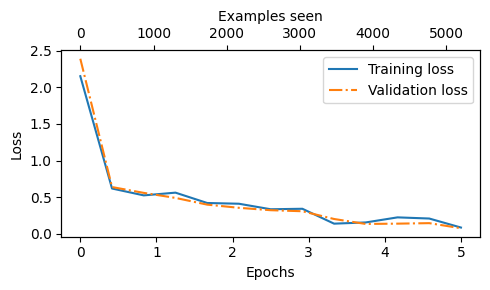

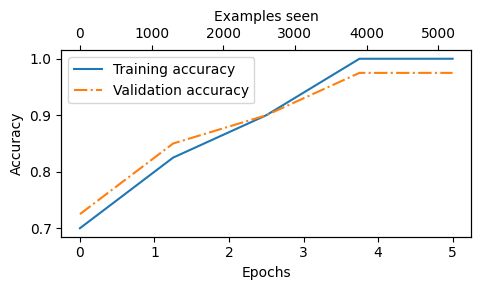

In [42]:

    # loss plot
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
    plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

    # accuracy plot
    epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
    plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

#using the model as a spam classifier

In [47]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()


    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [48]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [50]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [51]:
torch.save(model.state_dict(), "review_classifier.pth")

In [52]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>